# Table of Contents

1- [Package Imports](#package-imports)  
2- [Function Definitions](#function-definitions)  
3- [Variable Definitions](#variable-definitions)  
4- [Wrangling](#wrangling)  
&emsp;&emsp;   4.1. [Gather and Load Data](#gather)  
&emsp;&emsp;   4.2. [Assessment](#assess)  
&emsp;&emsp;   4.3. [Cleaning](#clean)  
&emsp;&emsp;&emsp;&emsp;   4.3.1. [Define](#define)  
&emsp;&emsp;&emsp;&emsp;   4.3.2. [Code and Test](#code)  
5- [Visualizations](#visualization)  

# Package Imports<a name="package-imports"></a>

In [1]:
#imports
import os
import requests
import json
import tweepy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO

# Function Definitions<a name="function-definitions"></a>

In [2]:
def initiate_api(consumer_key, consumer_secret, access_token, access_secret):
    """
    take the keys and secrets as input to initiate the twitter api
    """
    #run api with tokens given to function
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    return api

def capture_tweets(id_list, json_path, exceptions_path):
    """
    - Take a list of tweet ids to iterate through and a path to a JSON file to save tweets
    - Returns a list of exceptions and tweet ids that failed to be captured
    """
    if not os.path.exists(json_path):
        with open(json_path, mode='w') as output:
            exceptions_list=[]
            i=0
            for id in id_list:
                i+=1
                retry=0
                while True:
                    try:
                        tweet = api.get_status(id, tweet_mode='extended')
                        json.dump(tweet._json, output)
                        output.write('\n')
                        print(f'{i}: Tweet id {id} captured')
                        break
                    except tweepy.TweepError as e:
                        message = e.reason
                        if e.api_code == 144:
                            exceptions_list.append({'id':id,'message':message})
                            print(f'{i}: No tweet found with that ID:{id}')
                            break
                        elif e.api_code == 179:
                            exceptions_list.append({'id':id,'message':message})
                            print(f'{i}: Not authorized to capture tweet:{id}')
                            break
                        else:
                            if retry == 0:
                                print(f'{i}: Connection failed retrying to retrieve tweet: {id}')
                                retry += 1
                            elif retry <=10:
                                print(f'retry no. {retry} for tweet id {id}')
                                retry += 1
                            else:
                                exceptions_list.append({'id':id,'message':message})
                                print(f'{i}: Error capturing tweet:{id} look for it in exceptions_list')
                                break
        #export variables to file
        with open(exceptions_path, mode = 'wb') as exceptions:
            pickle.dump(exceptions_list, exceptions)
    else:
        print('JSON already exists: Using existing file')
        with open(exceptions_path, mode = 'rb') as exceptions:
            exceptions_list = pickle.load(exceptions)
    return exceptions_list

def download_predictions(url, path):
    """
    - Take predictions url to download and path of saved file as input
    - Downloads the url data to given file
    """
    if not os.path.exists(path):
        r = requests.get(url)
        #save predicitions to file
        with open(path, mode='wb') as f:
            f.write(r.content)
    else:
        print('Image predictions already exists: Using existing file')

def load_archive(archive_path):
    """
    take path as input to load enhanced twitter archive dataframe
    """
    archive = pd.read_csv(archive_path)
    return archive

def load_data(json_path, image_path):
    """
    take path as input to load enhanced twitter archive dataframe
    """
    capture = pd.read_json(json_path, lines=True)
    images = pd.read_csv(image_path, sep='\t')
    return capture, images


In [3]:
# Access tokens to the twitter api (provide your own keys)
consumer_key = API_key
consumer_secret = API_secret
access_token = access_token
access_secret = access_secret

# Variable Definitions <a name="variable-definitions"></a>

In [4]:
#Variables for image predictions datatype
#image predictions link
images_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#define path variables
#enhanced archive path
archive_path = 'twitter-archive-enhanced.csv'
#captured tweets data path
json_path = 'tweet_json.txt'
#image predictions path
image_path = images_url.split('/')[-1]
exceptions_path = 'exceptions'

# Wrangling <a name="wrangling"></a>

## 1- Gather and Load Data<a name="gather"></a>

In [5]:
archive = load_archive(archive_path)
download_predictions(images_url, image_path)
api = initiate_api(consumer_key, consumer_secret, access_token, access_secret)
exceptions_list = capture_tweets(archive.tweet_id, json_path, exceptions_path)
capture,images = load_data(json_path, image_path)

Image predictions already exists: Using existing file
JSON already exists: Using existing file


## 2- Assessment<a name="assess"></a>

In [6]:
archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [7]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
capture.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [9]:
capture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [10]:
images.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [11]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## 3- Cleaning <a name="clean"></a>
### Define <a name="define"></a>
- **Quality Issues**
1. Assess exceptions list for possible missing tweets
2. Tweets with no images, retweet count, favorite count
3. Need only original tweets; NO retweets NO replies
4. Deal with empty and useless columns
5. Timestamp dtype incorrect
6. Deal with duplicated columns due to different data sets
7. Clean data dtypes
8. NaN, None Values
9. deal with wrong info (wrong ratings, No names extracted, wrong types)
10. Tweets that are not about dogs
11. tweets that have bad predictions
- **Tidiness Issues**
1. Create new column that combines dog stage (doggo, floofer,pupper,puppo)
2. merge data together according to tweet ID
3. Separate dog info from tweet info from image info

### Code & Test <a name="code"></a>
#### 1. (Quality Issue) Assess exceptions list for possible missing tweets

In [12]:
exceptions = pd.DataFrame(exceptions_list).message.value_counts()
exceptions

[{'code': 144, 'message': 'No status found with that ID.'}]                        24
[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]     1
Name: message, dtype: int64

There are no tweets that need to be fetched

#### 2. (Tidiness Issue) merge data together according to tweet ID

##### Code

In [13]:
#Rename columns to know the source of each data column, will be cleaned later
archive_renamed = archive.copy().rename(columns=(lambda x: x+'_archive'))
capture_renamed = capture.copy().rename(columns=(lambda x: x+'_capture'))
images_renamed = images.copy().rename(columns=(lambda x: x+'__images'))
#merge data on tweet ids
merged_data = archive_renamed.merge(capture_renamed,  how='left', left_on='tweet_id_archive',right_on='id_capture')
merged_data = merged_data.merge(images_renamed,  how='left', left_on='tweet_id_archive',right_on='tweet_id__images')

##### Test

In [14]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   tweet_id_archive                       2356 non-null   int64              
 1   in_reply_to_status_id_archive          78 non-null     float64            
 2   in_reply_to_user_id_archive            78 non-null     float64            
 3   timestamp_archive                      2356 non-null   object             
 4   source_archive                         2356 non-null   object             
 5   text_archive                           2356 non-null   object             
 6   retweeted_status_id_archive            181 non-null    float64            
 7   retweeted_status_user_id_archive       181 non-null    float64            
 8   retweeted_status_timestamp_archive     181 non-null    object             
 9   expanded

All data columns from the three datasets merged successfully

#### 3. (Quality Issue) Tweets with no images, retweet count, favorite count

##### Code

In [15]:
merged_clean = merged_data.copy().dropna(subset=['tweet_id__images', 'retweet_count_capture', 'favorite_count_capture'])

##### Test

In [16]:
merged_data.query('tweet_id__images == "NaN" | retweet_count_capture == "NaN" | favorite_count_capture == "NaN"').shape[0]

297

In [17]:
merged_clean.query('tweet_id__images == "NaN" | retweet_count_capture == "NaN" | favorite_count_capture == "NaN"').shape[0]

0

No remaining tweets with no images, retweet count, favorite count

#### 4. (Quality Issue) Need only original tweets; NO retweets NO replies

##### Code

In [18]:
merged_clean = merged_clean.drop(index=merged_clean.query('retweeted_status_id_archive != "NaN" | in_reply_to_status_id_archive != "NaN"').index, errors='ignore')

##### Test

In [19]:
merged_data.query('retweeted_status_id_archive != "NaN" | in_reply_to_status_id_archive != "NaN"').shape[0]

259

In [20]:
merged_clean.query('retweeted_status_id_archive != "NaN" | in_reply_to_status_id_archive != "NaN"').shape[0]

0

No remaining tweets with retweets or replies

#### 5. (Quality Issue) Deal with empty and useless columns

##### inspect programmatically

In [21]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   tweet_id_archive                       1964 non-null   int64              
 1   in_reply_to_status_id_archive          0 non-null      float64            
 2   in_reply_to_user_id_archive            0 non-null      float64            
 3   timestamp_archive                      1964 non-null   object             
 4   source_archive                         1964 non-null   object             
 5   text_archive                           1964 non-null   object             
 6   retweeted_status_id_archive            0 non-null      float64            
 7   retweeted_status_user_id_archive       0 non-null      float64            
 8   retweeted_status_timestamp_archive     0 non-null      object             
 9   expanded

##### Code

In [22]:
merged_clean = merged_clean.dropna(axis=1, how='all')

##### Test

In [23]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   tweet_id_archive                       1964 non-null   int64              
 1   timestamp_archive                      1964 non-null   object             
 2   source_archive                         1964 non-null   object             
 3   text_archive                           1964 non-null   object             
 4   expanded_urls_archive                  1964 non-null   object             
 5   rating_numerator_archive               1964 non-null   int64              
 6   rating_denominator_archive             1964 non-null   int64              
 7   name_archive                           1964 non-null   object             
 8   doggo_archive                          1964 non-null   object             
 9   floofer_

No empty columns left

##### inspect column values visually

In [24]:
for column in merged_clean.columns:
    print(f'\n{column}:\n')
    print(merged_clean[column].value_counts())


tweet_id_archive:

685532292383666176    1
809920764300447744    1
759923798737051648    1
672082170312290304    1
667160273090932737    1
                     ..
692417313023332352    1
667119796878725120    1
688828561667567616    1
834931633769889797    1
700151421916807169    1
Name: tweet_id_archive, Length: 1964, dtype: int64

timestamp_archive:

2017-05-31 04:27:59 +0000    1
2016-12-22 17:23:53 +0000    1
2016-02-11 03:02:54 +0000    1
2015-12-08 03:57:26 +0000    1
2017-05-06 23:49:50 +0000    1
                            ..
2017-02-23 01:22:14 +0000    1
2016-03-08 21:23:50 +0000    1
2015-11-28 19:04:19 +0000    1
2016-12-15 02:14:29 +0000    1
2015-12-01 20:35:22 +0000    1
Name: timestamp_archive, Length: 1964, dtype: int64

source_archive:

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1926
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweet

{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 676146336014667776, 'id_str': '676146336014667776', 'indices': [38, 61], 'media_url': 'http://pbs.twimg.com/media/CWIngp5WEAAJOy3.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CWIngp5WEAAJOy3.jpg', 'url': 'https://t.co/lmQRrNxaQu', 'display_url': 'pic.twitter.com/lmQRrNxaQu', 'expanded_url': 'https://twitter.com/dog_rates/status/676146341966438401/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, 'h': 510, 'resize': 'fit'}, 'medium': {'w': 1024, 'h': 768, 'resize': 'fit'}, 'large': {'w': 1024, 'h': 768, 'resize': 'fit'}}}]}                                                                                    1
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 666804340162732032, 'id_str': '666804340162732032', 'indices': [112, 135], 'media_url': 'http://pbs.twimg.com/media/CUD3A7YWoAA82N0.jpg', 'media_url_https': 

##### Code

In [25]:
#drop useless columns
useless_list = ['source_archive', 'truncated_capture', 'display_text_range_capture', 'entities_capture', 'extended_entities_capture', 'source_capture', 'user_capture', 'place_capture', 'is_quote_status_capture', 'favorited_capture', 'retweeted_capture', 'possibly_sensitive_capture', 'possibly_sensitive_appealable_capture', 'lang_capture', 'in_reply_to_screen_name_capture']

merged_clean = merged_clean.drop(columns=useless_list, errors='ignore')

##### Test

In [26]:
#check if columns in the useless list are dropped
i = 0
for column in useless_list:
    if column in merged_clean.columns:
        i+=1
print(f'{i} useless columns remaining')

0 useless columns remaining


#### 6. (Quality Issue) Timestamp dtype incorrect

In [27]:
merged_clean['timestamp_archive'].dtype

dtype('O')

In [28]:
merged_clean['timestamp_archive'] = pd.to_datetime(merged_clean.timestamp_archive)

##### Test

In [29]:
merged_clean['timestamp_archive'].dtype

datetime64[ns, UTC]

#### 7. (Quality Issue) Deal with duplicated columns due to different data sets

##### Code

In [30]:
#6 Deal with duplicated columns due to different data sets
used_column =[]
duplicated = []
for column1 in merged_clean.columns:
    used_column.append(column1)
    for column2 in merged_clean.columns:
        if (column1 == column2) or (column2 in used_column) or (column2 in duplicated):
            continue
        if (merged_clean[column1] == merged_clean[column2]).sum() == merged_clean[column2].notna().sum():
            print(f'{column2} is a duplicate')
            duplicated.append(column2)
print(f'{len(duplicated)} duplicate columns found')
merged_clean = merged_clean.drop(columns=duplicated, errors='ignore')

#clean appended part to column names
merged_clean.rename(columns=(lambda x: x.replace('_archive','').replace('_capture','').replace('__images','')), inplace=True)

id_capture is a duplicate
id_str_capture is a duplicate
tweet_id__images is a duplicate
created_at_capture is a duplicate
full_text_capture is a duplicate
5 duplicate columns found


##### Test

In [31]:
#check if columns in the useless list are dropped
i = 0
for column in duplicated:
    if column in merged_clean.columns:
        i+=1
print(f'{i} duplicate columns remaining')

0 duplicate columns remaining


#### 8. (Quality Issue) Clean data dtypes (string = False because string raises keyerror when plotting)

In [32]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   int64              
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   text                1964 non-null   object             
 3   expanded_urls       1964 non-null   object             
 4   rating_numerator    1964 non-null   int64              
 5   rating_denominator  1964 non-null   int64              
 6   name                1964 non-null   object             
 7   doggo               1964 non-null   object             
 8   floofer             1964 non-null   object             
 9   pupper              1964 non-null   object             
 10  puppo               1964 non-null   object             
 11  retweet_count       1964 non-null   float64            
 12  favorite_count      1964 non-null 

##### Code

In [33]:
merged_clean = merged_clean.convert_dtypes(convert_string=False)

##### Test

In [34]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   Int64              
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   text                1964 non-null   object             
 3   expanded_urls       1964 non-null   object             
 4   rating_numerator    1964 non-null   Int64              
 5   rating_denominator  1964 non-null   Int64              
 6   name                1964 non-null   object             
 7   doggo               1964 non-null   object             
 8   floofer             1964 non-null   object             
 9   pupper              1964 non-null   object             
 10  puppo               1964 non-null   object             
 11  retweet_count       1964 non-null   Int64              
 12  favorite_count      1964 non-null 

##### Check info after cleaning quality issues

In [35]:
merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   Int64              
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   text                1964 non-null   object             
 3   expanded_urls       1964 non-null   object             
 4   rating_numerator    1964 non-null   Int64              
 5   rating_denominator  1964 non-null   Int64              
 6   name                1964 non-null   object             
 7   doggo               1964 non-null   object             
 8   floofer             1964 non-null   object             
 9   pupper              1964 non-null   object             
 10  puppo               1964 non-null   object             
 11  retweet_count       1964 non-null   Int64              
 12  favorite_count      1964 non-null 

#### 9. (Tidiness Issues) Create new column that combines dog stage (doggo, floofer,pupper,puppo)

##### Code

In [36]:
merged_tidy = merged_clean.copy()

stage_list = ['doggo','floofer','pupper','puppo']
for column in stage_list:
    merged_tidy.loc[merged_tidy[column] == "None", column] = ''
# merge the four columns into one 
merged_tidy['stage'] = merged_tidy.doggo+' '+merged_tidy.floofer+' '+merged_tidy.pupper+' '+merged_tidy.puppo
merged_tidy['stage'].value_counts()

                   1662
  pupper            201
doggo                62
   puppo             22
doggo  pupper         8
 floofer              7
doggo   puppo         1
doggo floofer         1
Name: stage, dtype: int64

In [37]:
#Clean messy representations after merging 
merged_tidy['stage'] = merged_tidy['stage'].apply(lambda x: '-'.join(x.title().split()))
merged_tidy.loc[merged_tidy.stage == '', 'stage'] = 'None'
# Drop the four separate columns
merged_tidy = merged_tidy.drop(columns=stage_list, errors='ignore')

##### Test

In [38]:
#Show clean representation
merged_tidy['stage'].value_counts()

None             1662
Pupper            201
Doggo              62
Puppo              22
Doggo-Pupper        8
Floofer             7
Doggo-Puppo         1
Doggo-Floofer       1
Name: stage, dtype: int64

In [39]:
#check if columns in the useless list are dropped
i = 0
for column in stage_list:
    if column in merged_tidy.columns:
        i+=1
print(f'{i} useless stage columns remaining')

0 useless stage columns remaining


#### 10- (Quality Issue) clean stage data that has double types visually

##### Code

In [40]:
# print tweets that have double stage and print for inspection
double_stage = ["Doggo-Pupper","Doggo-Floofer","Doggo-Puppo"]
stage_index = merged_tidy.query('stage in @double_stage').index
for index in stage_index:
    print(f'\n{merged_tidy.stage[index]} {index}:')
    print(f'{merged_tidy.text[index]}')


Doggo-Puppo 191:
Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel

Doggo-Floofer 200:
At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk

Doggo-Pupper 460:
This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7

Doggo-Pupper 531:
Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho

Doggo-Pupper 575:
This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj

Doggo-Pupper 705:
This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper.

In [41]:
i=0
for index in stage_index:
    stage = merged_tidy.loc[[index],'stage'].values
    if stage in double_stage:
        i+=1
        print(f'{index} is {stage}')

191 is ['Doggo-Puppo']
200 is ['Doggo-Floofer']
460 is ['Doggo-Pupper']
531 is ['Doggo-Pupper']
575 is ['Doggo-Pupper']
705 is ['Doggo-Pupper']
889 is ['Doggo-Pupper']
956 is ['Doggo-Pupper']
1063 is ['Doggo-Pupper']
1113 is ['Doggo-Pupper']


In [42]:
#Clean to correct stage with code
merged_tidy.loc[[191], 'stage'] = 'Puppo'
merged_tidy.loc[[200], 'stage'] = 'Doggo'
merged_tidy.loc[[460], 'stage'] = 'Pupper'
merged_tidy.loc[[575], 'stage'] = 'Pupper'
merged_tidy.loc[[705], 'stage'] = 'not-dog'
merged_tidy.loc[[956], 'stage'] = 'not-rating'

#drop some tweets
stage_index_drop = merged_tidy.query('stage in ["not-dog","not-rating"]').index
merged_tidy = merged_tidy.drop(index=stage_index_drop, errors='ignore')

##### Test

In [43]:
i=0
for index in stage_index:
    try:
        stage = merged_tidy.loc[[index],'stage'].values
        if stage in double_stage:
            i+=1
            print(f'{index} was left as is')
        else:
            print(f'{index} already corrected to {stage}')
    except KeyError:
        print(f'{index} already dropped because it was irrelevant')

191 already corrected to ['Puppo']
200 already corrected to ['Doggo']
460 already corrected to ['Pupper']
531 was left as is
575 already corrected to ['Pupper']
705 already dropped because it was irrelevant
889 was left as is
956 already dropped because it was irrelevant
1063 was left as is
1113 was left as is


#### 11. (Quality Issue) drop tweets with False in any of the three predictions considered as not dog

In [44]:
merged_tidy.query('(p1_dog != True) or (p2_dog != True) or (p3_dog != True)', engine='python').shape[0]

775

##### Code

In [45]:
merged_tidy = merged_tidy.query('(p1_dog == True and p2_dog == True and p3_dog == True)', engine='python')

##### Test

In [46]:
merged_tidy.query('(p1_dog != True) or (p2_dog != True) or (p3_dog != True)', engine='python').shape[0]

0

Deal with only dog tweets

#### 12. (Tidiness Issues) store dog info, tweet info and image info in separate datasets and files

##### Code

In [47]:
tweet_info = merged_tidy[['tweet_id', 'timestamp', 'text', 'expanded_urls', 'retweet_count', 'favorite_count']].copy()
dog_info = merged_tidy[['tweet_id', 'name', 'stage', 'rating_numerator', 'rating_denominator']].copy()
image_info = merged_tidy[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']].copy()

##### Test

In [48]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1187 entries, 1 to 2355
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1187 non-null   Int64              
 1   timestamp       1187 non-null   datetime64[ns, UTC]
 2   text            1187 non-null   object             
 3   expanded_urls   1187 non-null   object             
 4   retweet_count   1187 non-null   Int64              
 5   favorite_count  1187 non-null   Int64              
dtypes: Int64(3), datetime64[ns, UTC](1), object(2)
memory usage: 68.4+ KB


In [49]:
dog_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1187 entries, 1 to 2355
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1187 non-null   Int64 
 1   name                1187 non-null   object
 2   stage               1187 non-null   object
 3   rating_numerator    1187 non-null   Int64 
 4   rating_denominator  1187 non-null   Int64 
dtypes: Int64(3), object(2)
memory usage: 59.1+ KB


In [50]:
image_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1187 entries, 1 to 2355
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1187 non-null   Int64  
 1   jpg_url   1187 non-null   object 
 2   img_num   1187 non-null   Int64  
 3   p1        1187 non-null   object 
 4   p1_conf   1187 non-null   float64
 5   p1_dog    1187 non-null   boolean
 6   p2        1187 non-null   object 
 7   p2_conf   1187 non-null   float64
 8   p2_dog    1187 non-null   boolean
 9   p3        1187 non-null   object 
 10  p3_conf   1187 non-null   float64
 11  p3_dog    1187 non-null   boolean
dtypes: Int64(2), boolean(3), float64(3), object(4)
memory usage: 102.0+ KB


In [51]:
merged_tidy.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'stage'],
      dtype='object')

In [52]:
merged_tidy = merged_tidy[['tweet_id', 'timestamp', 'text', 'expanded_urls', 'retweet_count', 'favorite_count',
        'name', 'stage', 'rating_numerator','rating_denominator',
        'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
        'p2_dog', 'p3', 'p3_conf', 'p3_dog']]

In [53]:
if not os.path.exists('work'):
    os.makedirs('work')
merged_tidy.to_csv('work/twitter_archive_master.csv',index=False)
tweet_info.to_csv('work/tweets.csv',index=False)
dog_info.to_csv('work/dog.csv',index=False)
image_info.to_csv('work/image.csv',index=False)

# Visualizations <a name="visualization"></a>

In [54]:
#Create folder for graphs
if not os.path.exists('work/graphs'):
    os.makedirs('work/graphs')

In [55]:
#extract extra data from timestamp
merged_tidy['hour'] = merged_tidy.timestamp.dt.hour
merged_tidy['month'] = merged_tidy.timestamp.dt.month
merged_tidy['year'] = merged_tidy.timestamp.dt.year
merged_tidy['month_name'] = merged_tidy.timestamp.dt.month_name()

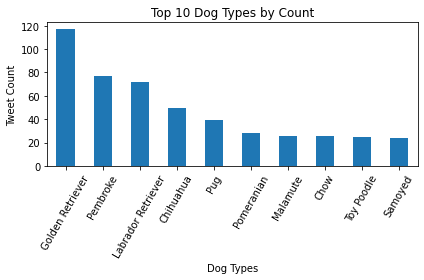

In [56]:
#Bar chart for top 10 dog types in dataset
merged_tidy.p1.value_counts()[:10].rename(index=(lambda x:x.replace('_',' ').title())).plot.bar()
plt.xlabel('Dog Types')
plt.xticks(rotation='60')
plt.ylabel('Tweet Count')
plt.title('Top 10 Dog Types by Count')
plt.tight_layout()
plt.savefig('work/graphs/top_types_bar.jpg')

In [57]:
merged_tidy.p1.value_counts()[:10].rename(index=(lambda x:x.replace('_',' ').title()))

Golden Retriever      117
Pembroke               77
Labrador Retriever     72
Chihuahua              50
Pug                    39
Pomeranian             28
Malamute               26
Chow                   26
Toy Poodle             25
Samoyed                24
Name: p1, dtype: int64

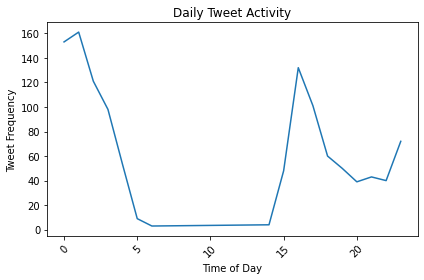

In [58]:
#check peak hour for tweet activity UTC +00
merged_tidy.hour.value_counts().sort_index().plot.line()
plt.xlabel('Time of Day')
plt.xticks(rotation='45')
plt.ylabel('Tweet Frequency')
plt.title('Daily Tweet Activity')
plt.tight_layout()
plt.savefig('work/graphs/daily_activity_line.jpg')

In [59]:
merged_tidy.hour.value_counts().sort_index()

0     153
1     161
2     121
3      98
4      53
5       9
6       3
14      4
15     48
16    132
17    101
18     60
19     50
20     39
21     43
22     40
23     72
Name: hour, dtype: int64

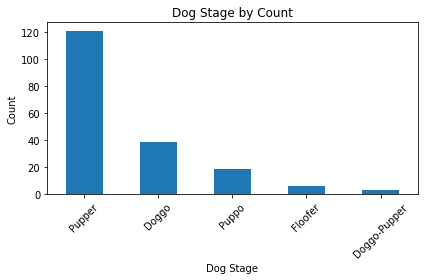

In [60]:
#most rated dog stage by Count
merged_tidy.query('stage != "None"').stage.value_counts().plot.bar()
plt.xlabel('Dog Stage')
plt.xticks(rotation='45')
plt.ylabel('Count')
plt.title('Dog Stage by Count')
plt.tight_layout()
plt.savefig('work/graphs/stage_count_bar.jpg')

In [61]:
merged_tidy.query('stage != "None"').stage.value_counts()

Pupper          121
Doggo            39
Puppo            19
Floofer           6
Doggo-Pupper      3
Name: stage, dtype: int64

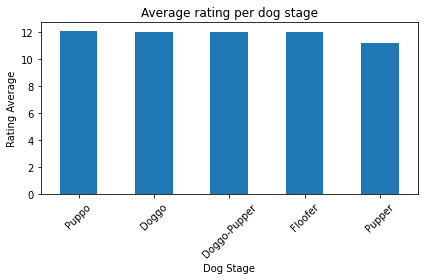

In [62]:
#Top rated dog stage
pivot = merged_tidy.query('stage != "None"').pivot_table(index='stage',values='rating_numerator',aggfunc='mean')
pivot.sort_values(by='rating_numerator', ascending=False).plot.bar(legend=None)
plt.xlabel('Dog Stage')
plt.xticks(rotation='45')
plt.ylabel('Rating Average')
plt.title('Average rating per dog stage')
plt.tight_layout()
plt.savefig('work/graphs/stage_rating_bar.jpg')

In [63]:
pivot.index.names = ['Stage']
pivot.sort_values(by='rating_numerator', ascending=False)

,rating_numerator
Stage,
Puppo,12.105263
Doggo,12.000000
Doggo-Pupper,12.000000
Floofer,12.000000
Pupper,11.181818


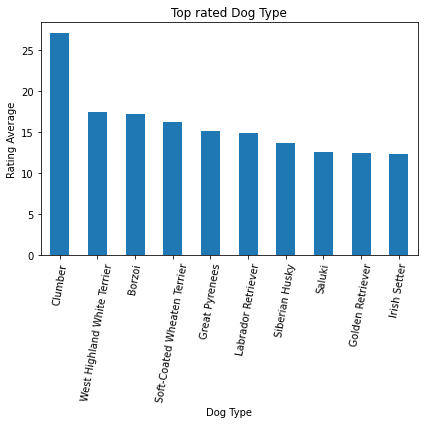

In [64]:
#Top rated dog type
pivot = merged_tidy.pivot_table(index='p1',values='rating_numerator',aggfunc='mean')
pivot = pivot.sort_values(by='rating_numerator' ,ascending=False)[:10].rename(index=(lambda x: x.title().replace('_',' ')))
pivot.plot.bar(legend=None, figsize=(6,6))
plt.xlabel('Dog Type')
plt.xticks(rotation='80')
plt.ylabel('Rating Average')
plt.title('Top rated Dog Type')
plt.tight_layout()
plt.savefig('work/graphs/type_rating_bar.jpg')

In [65]:
pivot.index.names = ['Dog Type']
pivot

,rating_numerator
Dog Type,
Clumber,27.000000
West Highland White Terrier,17.454545
Borzoi,17.200000
Soft-Coated Wheaten Terrier,16.222222
Great Pyrenees,15.153846
Labrador Retriever,14.875000
Siberian Husky,13.647059
Saluki,12.500000
Golden Retriever,12.393162


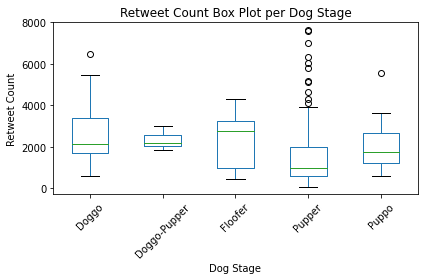

In [66]:
#Box plot for retweet count grouped by stage
pivot = merged_tidy.query('stage != "None" & retweet_count <= 8000',engine='python').pivot_table(index='tweet_id',values='retweet_count', columns='stage',aggfunc='sum')
pivot.plot.box()
plt.xlabel('Dog Stage')
plt.xticks(rotation='45')
plt.ylabel('Retweet Count')
plt.title('Retweet Count Box Plot per Dog Stage')
plt.tight_layout()
plt.savefig('work/graphs/stage_retweets_box.jpg')

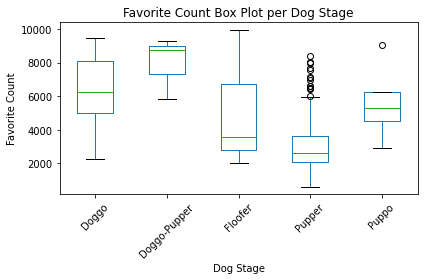

In [67]:
#Box plot for favorite count grouped by stage
pivot = merged_tidy.query('stage != "None" & favorite_count <= 10000',engine='python').pivot_table(index='tweet_id',values='favorite_count', columns='stage',aggfunc='sum')
pivot.plot.box()
plt.xlabel('Dog Stage')
plt.xticks(rotation='45')
plt.ylabel('Favorite Count')
plt.title('Favorite Count Box Plot per Dog Stage')
plt.tight_layout()
plt.savefig('work/graphs/stage_favorite_box.jpg')

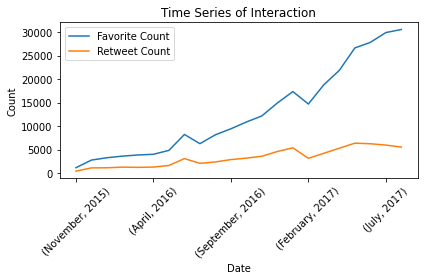

In [68]:
#Line Charts for tweets, retweets and favorite count
pivot = merged_tidy.pivot_table(index=['year','month','month_name'],values=['favorite_count','retweet_count'],aggfunc='mean')
pivot = pivot.reset_index('month',drop=True).reorder_levels(['month_name','year']).rename(columns=(lambda x: x.title().replace('_',' ')))
pivot.plot.line()
plt.xlabel('Date')
plt.xticks(rotation='45')
plt.ylabel('Count')
plt.title('Time Series of Interaction')
plt.tight_layout()
plt.savefig('work/graphs/interaction_line.jpg')

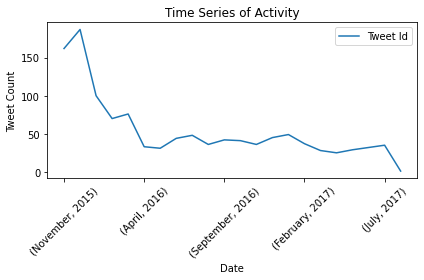

In [69]:
pivot = merged_tidy.pivot_table(index=['year','month','month_name'],values=['tweet_id'],aggfunc='count')
pivot = pivot.reset_index('month',drop=True).reorder_levels(['month_name','year']).rename(columns=(lambda x: x.title().replace('_',' ')))
pivot.plot.line()
plt.xlabel('Date')
plt.xticks(rotation='45')
plt.ylabel('Tweet Count')
plt.title('Time Series of Activity')
plt.tight_layout()
plt.savefig('work/graphs/activity_line.jpg')

In [70]:
pivot

,,Tweet Id
month_name,year,
November,2015,162
December,2015,187
January,2016,100
February,2016,70
March,2016,76
April,2016,33
May,2016,31
June,2016,44
July,2016,48


In [71]:
#Tweet of the image used as report cover
cover_url = merged_tidy.query('p1 == "clumber"', engine='python')['jpg_url'][763]

In [72]:
r = requests.get(cover_url)
i = Image.open(BytesIO(r.content))
image_file_format = cover_url.split('.')[-1]
i.save('work/cover' + '.' + image_file_format)